### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import scipy 
import sklearn
import math
from collections import Counter
from sklearn.metrics import multilabel_confusion_matrix
from scipy import spatial

### DATASET LOADING

In [2]:
data = pd.read_csv(r'C:\Users\vardh\OneDrive\Desktop\data.csv')
labels = pd.read_csv(r'C:\Users\vardh\OneDrive\Desktop\label.csv', names=['label'], header=None)

### DATASET SPLITTING

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split( data, test_size=0.08, random_state=42)
train_labels, test_labels = train_test_split( labels, test_size=0.08, random_state=42)

### MODEL DEFINITION

In [4]:
class KMeans:
    
    # Function to calculate Sum of Squared Errors
    def SSE_Calculation(self, V, C, data):
        SSE = 0
        for cluster in C:
            sse_cluster = 0
            for j in C[cluster]:
                dp = list(data.iloc[int(j)])
                for a,b in zip(V[cluster],dp):
                    sse_cluster += math.pow(a-b,2)
            SSE+=sse_cluster
        return SSE
    
    # Initializing the centroids
    def Initialize_Centroids(self,data,K):
        l = data.shape[0]
        centroid_value_dict={}
        for i in range(K):
            rnd = np.random.randint(0, l-1)
            centroid_value_dict[i] = data.iloc[rnd]
        return centroid_value_dict
    
    # Calculating the Jaccard Similarity based on the centroid data and the data points
    def jaccard_similarity(self,centroid,data_point):
        intersection = len(list(set(centroid).intersection(data_point)))
        union = (len(set(centroid)) + len(set(data_point))) - intersection
        return float(intersection) / union

    # Model Training
    def train_model(self,data,K,max_iter=20,similarity_measure=1,tol=10):
        centroid_value_dict = self.Initialize_Centroids(data,K)
        new_centroid_value_dict = {}
        count = 0
        centroid_dict = {}
        convergence = False
        while((count<max_iter) and not convergence):
            
            for i in list(centroid_value_dict.keys()):
                centroid_dict[i]=[]
            for i in range(data.shape[0]):
                x = data.iloc[i]
                if similarity_measure==1 :
                    distance_measure = [np.linalg.norm(x-centroid_value_dict[j])  for j in centroid_value_dict]
                    idx = np.argmin(distance_measure)
                    centroid_dict[idx].append(i)
                elif similarity_measure==2 :
                    distance_measure = [self.jaccard_similarity(list(x),centroid_value_dict[j]) for j in centroid_value_dict]
                    idx = np.argmax(distance_measure)
                    centroid_dict[idx].append(i)
                elif similarity_measure==3 :
                    distance_measure = [1-scipy.spatial.distance.cosine(x,list(centroid_value_dict[j]))  for j in centroid_value_dict]
                    idx = np.argmax(distance_measure)
                    centroid_dict[idx].append(i)
                
                prev_centroids=dict(centroid_value_dict)
                
            
            for i in centroid_dict:
                if len(centroid_dict[i]):
                    dps_centroid = centroid_dict[i]
                    centroid_value_dict[i] = np.average(data.iloc[dps_centroid],axis=0)
            
            
            current_tol=-1
            for i in centroid_value_dict:
                prev_centroid_point = prev_centroids[i]
                new_centroid_point = centroid_value_dict[i]
                change = np.sum(np.absolute(new_centroid_point-prev_centroid_point))
                current_tol = max(change, current_tol)
                
            print("Iteration : ", count,", Tolerance : ", current_tol)
            
            count+=1
            if (current_tol<10):
                convergence = True
                break
        return centroid_value_dict,centroid_dict
    

### PREDICTING LABELS FOR THE CLUSTER

In [5]:
def predict_cluster_labels(C, S, labels):
    cluster_labels = np.zeros(10,dtype=int)
    for c in C:
        labels_of_points = []
        for point in S[c]:
            labels_of_points.extend(labels.iloc[point])
        counter = Counter(labels_of_points)
        try:
            cluster_labels[c] = max(counter, key=counter.get)
        except:
            cluster_labels[c] = np.random.randint(0,9)
    return cluster_labels

In [6]:
def jaccard_similarity(list1, list2):
        intersection = len(list(set(list1).intersection(list2)))
        union = (len(set(list1)) + len(set(list2))) - intersection
        return float(intersection) / union

### MEASURING THE ACCURACY

In [7]:
def accuracy(centroids, centroid_Labels, test_data, true_labels, similarity_measure=1):
    y_true = list(true_labels['label']);
    y_pred = []
    for index in range(test_data.shape[0]):
        featureset = test_data.iloc[index]
        if similarity_measure==1:
            distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
            classification = distances.index(min(distances))
            y_pred.append(centroid_Labels[classification])
        elif similarity_measure==2:
            similarity = [jaccard_similarity(featureset, centroids[centroid]) for centroid in centroids]
            classification = similarity.index(max(similarity))
            y_pred.append(centroid_Labels[classification]) 
        elif similarity_measure==3:
            similarity = [1 - spatial.distance.cosine(featureset, centroids[centroid]) for centroid in centroids]
            classification = similarity.index(max(similarity))
            y_pred.append(centroid_Labels[classification])
    denominator = test_data.shape[0]
    correctly_classified = 0
    for i in range(0,len(y_pred)):
        if y_true[i] == y_pred[i]:
            correctly_classified += 1
    accuracy = correctly_classified/denominator
    return accuracy

### LISTS FOR STORING THE RESULTS

In [8]:
accuracy_list = []
sse_list = []

### EUCLEDIAN SIMILARITY METRIC

In [9]:
# Model Training
model_Eucledian = KMeans()
centroids_Eucledian,clusters_Eucledian = model_Eucledian.train_model(data, 10, max_iter=100, similarity_measure=1)

Iteration :  0 , Tolerance :  26874.17551622419
Iteration :  1 , Tolerance :  4229.5185557488385
Iteration :  2 , Tolerance :  3522.4969908300363
Iteration :  3 , Tolerance :  1954.7047818865285
Iteration :  4 , Tolerance :  1908.7155911980597
Iteration :  5 , Tolerance :  2352.3895223604077
Iteration :  6 , Tolerance :  2334.243627939437
Iteration :  7 , Tolerance :  1795.3535492638734
Iteration :  8 , Tolerance :  1202.331250984188
Iteration :  9 , Tolerance :  1052.2303839435504
Iteration :  10 , Tolerance :  1135.1265257968482
Iteration :  11 , Tolerance :  1151.505568554501
Iteration :  12 , Tolerance :  1186.54753491299
Iteration :  13 , Tolerance :  1088.2466458708573
Iteration :  14 , Tolerance :  871.8312626230668
Iteration :  15 , Tolerance :  705.7547546869162
Iteration :  16 , Tolerance :  619.8129609960465
Iteration :  17 , Tolerance :  643.804942713512
Iteration :  18 , Tolerance :  681.1133060558349
Iteration :  19 , Tolerance :  686.48835107334
Iteration :  20 , Toleran

In [10]:
# SSE Calculation
Euclidean_SSE = model_Eucledian.SSE_Calculation(centroids_Eucledian,clusters_Eucledian,data)

In [11]:
print("SSE with Euclidean Similarity:",Euclidean_SSE)
sse_list.append(Euclidean_SSE)

SSE with Euclidean Similarity: 25469352400.99587


In [12]:
# Cluster Labelling
cluster_labels_Euclidean = predict_cluster_labels(centroids_Eucledian,clusters_Eucledian,labels)
cluster_labels_Euclidean

array([2, 0, 3, 3, 7, 1, 0, 4, 8, 9])

In [13]:
# Accuracy Calculation
Accuracy_Euclidean = accuracy(centroids_Eucledian, cluster_labels_Euclidean,test_data,test_labels)
Accuracy_Euclidean
accuracy_list.append(Accuracy_Euclidean)

### JACCARD SIMILARITY METRIC

In [14]:
# Model Training
model_Jaccard = KMeans()
centroids_Jaccard,clusters_Jaccard = model_Jaccard.train_model(data,10, max_iter=100,similarity_measure=2)


Iteration :  0 , Tolerance :  32756.157148990984
Iteration :  1 , Tolerance :  6837.526029130581
Iteration :  2 , Tolerance :  1305.1116322763446
Iteration :  3 , Tolerance :  1998.8942188414092
Iteration :  4 , Tolerance :  1628.9928280211197
Iteration :  5 , Tolerance :  934.1861491027151
Iteration :  6 , Tolerance :  1286.3552990081616
Iteration :  7 , Tolerance :  1617.9428767201043
Iteration :  8 , Tolerance :  1567.682167315057
Iteration :  9 , Tolerance :  1308.3374630613744
Iteration :  10 , Tolerance :  568.8622842398963
Iteration :  11 , Tolerance :  825.9260955306825
Iteration :  12 , Tolerance :  449.0599433264121
Iteration :  13 , Tolerance :  0.0


In [15]:
# SSE Calculation
Jaccard_SSE = model_Jaccard.SSE_Calculation(centroids_Jaccard,clusters_Jaccard,data)

In [16]:
print("SSE with Jaccard Similarity:",Jaccard_SSE)
sse_list.append(Jaccard_SSE)

SSE with Jaccard Similarity: 34361687572.938736


In [17]:
# Cluster Labelling
cluster_labels_Jaccard = predict_cluster_labels(centroids_Jaccard,clusters_Jaccard,labels)
cluster_labels_Jaccard

array([1, 4, 3, 3, 6, 2, 3, 4, 5, 7])

In [18]:
# Accuracy Calculation
Accuracy_Jaccard = accuracy(centroids_Jaccard, cluster_labels_Jaccard,test_data,test_labels)
Accuracy_Jaccard
accuracy_list.append(Accuracy_Jaccard)

### COSINE SIMILARITY METRIC

In [19]:
# Model Training
model_Cosine = KMeans()
centroids_Cosine,clusters_Cosine = model_Cosine.train_model(data,10, max_iter = 100,similarity_measure=3)

Iteration :  0 , Tolerance :  27361.689489751418
Iteration :  1 , Tolerance :  3867.947695343287
Iteration :  2 , Tolerance :  3592.807171761271
Iteration :  3 , Tolerance :  2312.498441004068
Iteration :  4 , Tolerance :  1781.8341188931554
Iteration :  5 , Tolerance :  1385.2884042338032
Iteration :  6 , Tolerance :  1027.665685825305
Iteration :  7 , Tolerance :  578.0276348606726
Iteration :  8 , Tolerance :  461.3062373399252
Iteration :  9 , Tolerance :  337.13491011859094
Iteration :  10 , Tolerance :  260.6295264850447
Iteration :  11 , Tolerance :  170.33585310871058
Iteration :  12 , Tolerance :  135.14775608399685
Iteration :  13 , Tolerance :  207.89399595697267
Iteration :  14 , Tolerance :  212.87536830225753
Iteration :  15 , Tolerance :  210.56170697431378
Iteration :  16 , Tolerance :  193.4810136062061
Iteration :  17 , Tolerance :  259.30790977760984
Iteration :  18 , Tolerance :  236.9759609373682
Iteration :  19 , Tolerance :  295.9293848810048
Iteration :  20 , To

In [20]:
# SSE Calculation
Cosine_SSE = model_Cosine.SSE_Calculation(centroids_Cosine,clusters_Cosine,data)
sse_list.append(Cosine_SSE)

In [21]:
# Cluster Labelling
cluster_labels_Cosine = predict_cluster_labels(centroids_Cosine,clusters_Cosine,labels)
cluster_labels_Cosine

array([0, 3, 3, 7, 0, 8, 1, 5, 2, 9])

In [22]:
# Accuracy Calculation
Accuracy_Cosine = accuracy(centroids_Cosine, cluster_labels_Cosine,test_data,test_labels)
Accuracy_Cosine
accuracy_list.append(Accuracy_Cosine)

### RESULTS

In [23]:
print("SSE for the Euclidean Similarity is :",Euclidean_SSE)
print("SSE for the Jaccard Similarity is :",Jaccard_SSE)
print("SSE for the Cosine Similarity is :",Cosine_SSE)

SSE for the Euclidean Similarity is : 25469352400.99587
SSE for the Jaccard Similarity is : 34361687572.938736
SSE for the Cosine Similarity is : 25411880140.148922


In [24]:
print("Accuracy for the Euclidean Similarity is :",Accuracy_Euclidean)
print("Accuracy for the Jaccard Similarity is :",Accuracy_Jaccard)
print("Accuracy for the Cosine Similarity is ",Accuracy_Cosine)

Accuracy for the Euclidean Similarity is : 0.07
Accuracy for the Jaccard Similarity is : 0.1075
Accuracy for the Cosine Similarity is  0.0875


### GRAPH PLOTS

Text(0, 0.5, 'Accuracy')

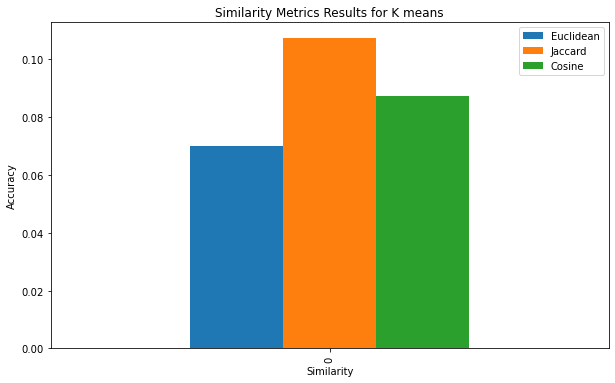

In [25]:
import pandas as pd
from matplotlib import pyplot as plt

plotdata = pd.DataFrame({

    "Euclidean":[accuracy_list[0]],

    "Jaccard":[accuracy_list[1]],

    "Cosine":[accuracy_list[2]]},

    )

plotdata.plot(kind="bar",figsize=(10, 6))

plt.title("Similarity Metrics Results for K means")

plt.xlabel("Similarity")

plt.ylabel("Accuracy")

Text(0, 0.5, 'SSE')

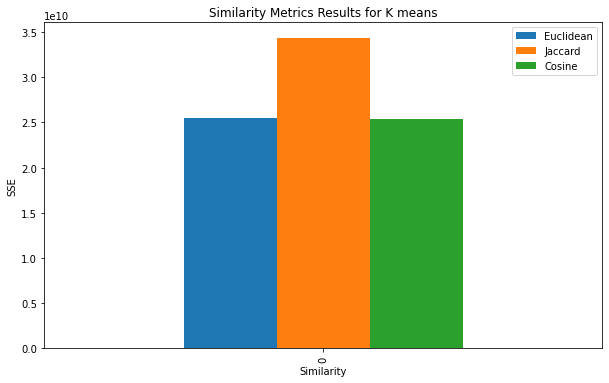

In [26]:
import pandas as pd

plotdata = pd.DataFrame({

    "Euclidean":[sse_list[0]],

    "Jaccard":[sse_list[1]],

    "Cosine":[sse_list[2]]},

    )

plotdata.plot(kind="bar",figsize=(10, 6))

plt.title("Similarity Metrics Results for K means")

plt.xlabel("Similarity")

plt.ylabel("SSE")